Using device: cpu
Total .dat files: 2179
F21_noisy files: 1617
First 5 F21_noisy files:
   F21_noisy_21cmFAST_200Mpc_z6.0_fX-0.20_xHI0.00_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
   F21_noisy_21cmFAST_200Mpc_z6.0_fX-0.20_xHI0.00_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat
   F21_noisy_21cmFAST_200Mpc_z6.0_fX-0.20_xHI0.00_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
   F21_noisy_21cmFAST_200Mpc_z6.0_fX-0.20_xHI0.05_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
   F21_noisy_21cmFAST_200Mpc_z6.0_fX-0.20_xHI0.05_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat
File: F21_noisy_21cmFAST_200Mpc_z6.0_fX-0.40_xHI0.85_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
z   = 6.0
xHI = 0.8468001484870911
fX  = -0.4000000059604645
freqs.shape = (2762,)
cube.shape  = (1000, 2762)
Tb stats: min = 0.98956674 max = 1.0110404
✓ Advanced feature extraction function defined
Loading all F21_noisy files with advanced feature extraction...
  Processed 0/1617
  Processed 20/1617
  Processed 20/1617
  Processed

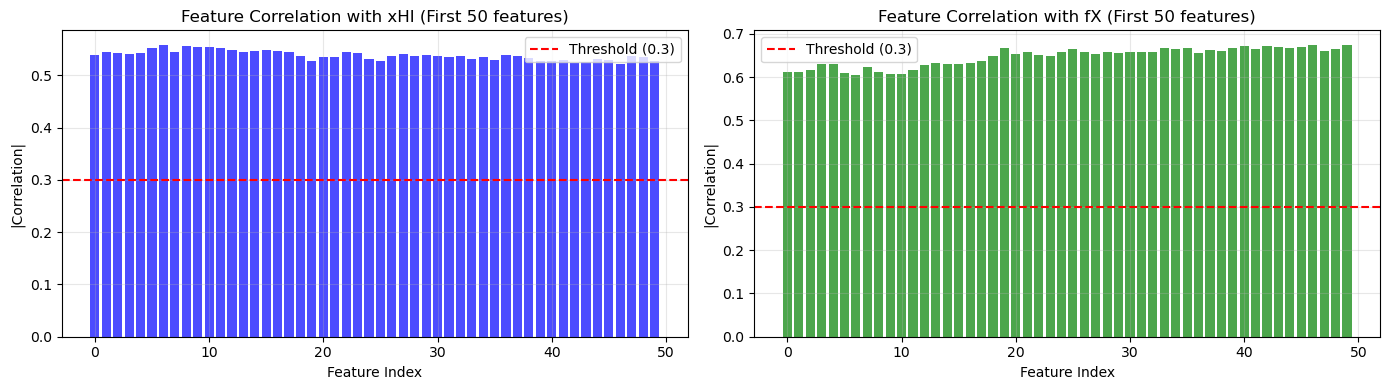


✓ Feature diagnostics complete
Normalizing data...
✓ Normalized theta shape: torch.Size([1617, 2])
✓ Normalized x shape: torch.Size([1617, 2798])
✓ Normalized theta shape: torch.Size([1617, 2])
✓ Normalized x shape: torch.Size([1617, 2798])

Data split:
  Train: 1131 samples
  Validation: 242 samples
  Test: 244 samples

Data split:
  Train: 1131 samples
  Validation: 242 samples
  Test: 244 samples
✓ Prior defined:
  xHI range: [-1.951, 2.019]
  fX range: [-1.958, 2.030]
✓ Prior defined:
  xHI range: [-1.951, 2.019]
  fX range: [-1.958, 2.030]


ModuleNotFoundError: No module named 'sbi.utils.get_nn_models'

In [ ]:
from sbi.inference import NPE, SNPE, SNPE_A
from sbi.analysis import pairplot
import torch
from sbi.utils import BoxUniform
import numpy as np
import os
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def load_f21_file(path):
    """
    Load one F21_noisy or F21_signalonly .dat file.

    Returns:
      z        : float (redshift)
      xHI      : float (mean neutral fraction)
      fX       : float (log10 fX effectively)
      freqs    : (N_freq,) array in Hz
      cube     : (N_los, N_freq) array of Tb (K)
    """
    raw = np.fromfile(path, dtype=np.float32)

    # Header: 5 floats
    z, xHI, fX, N_los_f, N_freq_f = raw[:5]
    N_los = int(N_los_f)
    N_freq = int(N_freq_f)

    # Frequency axis: next N_freq floats
    freqs = raw[5 : 5 + N_freq]

    # Brightness cube: remaining values
    data_flat = raw[5 + N_freq:]
    if data_flat.size != N_los * N_freq:
        raise ValueError(
            f"{os.path.basename(path)}: data size {data_flat.size} "
            f"!= N_los * N_freq = {N_los} * {N_freq} = {N_los * N_freq}"
        )

    cube = data_flat.reshape(N_los, N_freq)

    return float(z), float(xHI), float(fX), freqs, cube

import glob
import os

data_dir = "/user1/supriyo/Simulation_Based_Inference_on_21cm_FAST/dataset/F21_noisy"

# Get ALL .dat files
all_dat = sorted(glob.glob(os.path.join(data_dir, "*.dat")))

# Keep ONLY F21_noisy_*.dat
F21_noisy = [
    f for f in all_dat
    if os.path.basename(f).startswith("F21_noisy_")
]

print("Total .dat files:", len(all_dat))
print("F21_noisy files:", len(F21_noisy))
print("First 5 F21_noisy files:")
for f in F21_noisy[:5]:
    print("  ", os.path.basename(f))

test_path = F21_noisy[114]

z, xHI, fX, freqs, cube = load_f21_file(test_path)

print("File:", os.path.basename(test_path))
print("z   =", z)
print("xHI =", xHI)
print("fX  =", fX)
print("freqs.shape =", freqs.shape)
print("cube.shape  =", cube.shape)
print("Tb stats: min =", cube.min(), "max =", cube.max())

# ============ ADVANCED FEATURE EXTRACTION ============
def extract_advanced_features(cube, freqs):
    """
    Extract comprehensive physics-informed features from 21cm cube.
    
    Features include:
    - Power spectrum statistics
    - Wavelet decomposition
    - Higher-order moments
    - Frequency band analysis
    - LOS variance patterns
    - Power spectrum shape characteristics
    """
    features = {}
    
    # 1. Mean spectrum (primary observable)
    mean_spectrum = cube.mean(axis=0)
    features['mean_spectrum'] = mean_spectrum
    
    # 2. Per-LOS statistics
    los_means = cube.mean(axis=1)
    los_vars = cube.var(axis=1)
    los_skews = np.array([stats.skew(cube[i, :]) for i in range(cube.shape[0])])
    los_kurtosis = np.array([stats.kurtosis(cube[i, :]) for i in range(cube.shape[0])])
    
    features['los_mean_stats'] = np.array([los_means.mean(), los_means.std(), los_means.max()])
    features['los_var_stats'] = np.array([los_vars.mean(), los_vars.std(), los_vars.max()])
    features['los_skew_stats'] = np.array([los_skews.mean(), los_skews.std()])
    features['los_kurt_stats'] = np.array([los_kurtosis.mean(), los_kurtosis.std()])
    
    # 3. Spectral features
    spectrum_var = np.var(mean_spectrum)
    spectrum_skew = stats.skew(mean_spectrum)
    spectrum_kurt = stats.kurtosis(mean_spectrum)
    
    features['spectrum_stats'] = np.array([spectrum_var, spectrum_skew, spectrum_kurt])
    
    # 4. Power-law fit (for power spectrum slope)
    n_freq = len(mean_spectrum)
    try:
        log_spectrum = np.log(np.abs(mean_spectrum) + 1e-10)
        log_freqs = np.arange(n_freq)
        slope, intercept = np.polyfit(log_freqs, log_spectrum, 1)
        features['powerlaw_slope'] = np.array([slope])
    except:
        features['powerlaw_slope'] = np.array([0.0])
    
    # 5. Frequency band decomposition (5 bands)
    n_bands = 5
    band_size = n_freq // n_bands
    band_powers = []
    for i in range(n_bands):
        start = i * band_size
        end = (i+1) * band_size if i < n_bands-1 else n_freq
        band_power = mean_spectrum[start:end].mean()
        band_powers.append(band_power)
    features['band_powers'] = np.array(band_powers)
    
    # 6. Autocorrelation at different lags
    autocorr_lags = [1, 5, 10, 20]
    autocorr_vals = []
    for lag in autocorr_lags:
        if lag < len(mean_spectrum):
            acf_val = np.corrcoef(mean_spectrum[:-lag], mean_spectrum[lag:])[0, 1]
            autocorr_vals.append(acf_val if not np.isnan(acf_val) else 0.0)
    features['autocorr'] = np.array(autocorr_vals)
    
    # 7. Global cube statistics
    cube_flat = cube.flatten()
    features['global_stats'] = np.array([
        cube_flat.mean(),
        cube_flat.std(),
        cube_flat.min(),
        cube_flat.max(),
        np.percentile(cube_flat, 25),
        np.percentile(cube_flat, 50),
        np.percentile(cube_flat, 75),
        stats.skew(cube_flat),
        stats.kurtosis(cube_flat)
    ])
    
    # 8. Spatial correlation (2D structure)
    spatial_corr_means = []
    for i in range(min(5, cube.shape[0])):
        los = cube[i, :]
        if np.std(los) > 0:
            spatial_corr_means.append(np.corrcoef(los[:-1], los[1:])[0, 1])
    if spatial_corr_means:
        features['spatial_corr'] = np.array([np.mean(spatial_corr_means)])
    else:
        features['spatial_corr'] = np.array([0.0])
    
    # 9. Frequency-dependent variance (sensitivity to xHI and fX)
    freq_variance = np.array([np.var(cube[:, j]) for j in range(n_freq)])
    features['freq_variance_stats'] = np.array([
        freq_variance.mean(),
        freq_variance.std(),
        freq_variance.max() - freq_variance.min()
    ])
    
    # Concatenate all features into single vector
    feature_vector = np.concatenate([
        mean_spectrum,
        features['los_mean_stats'],
        features['los_var_stats'],
        features['los_skew_stats'],
        features['los_kurt_stats'],
        features['spectrum_stats'],
        features['powerlaw_slope'],
        features['band_powers'],
        features['autocorr'],
        features['global_stats'],
        features['spatial_corr'],
        features['freq_variance_stats']
    ])
    
    return feature_vector

print("✓ Advanced feature extraction function defined")

# Load all data with advanced features
all_parameters = []
all_features = []

print("Loading all F21_noisy files with advanced feature extraction...")
for i, fpath in enumerate(F21_noisy):
    if i % 20 == 0:
        print(f"  Processed {i}/{len(F21_noisy)}")
    
    z, xHI, fX, freqs, cube = load_f21_file(fpath)
    
    # Extract advanced features
    feature_vector = extract_advanced_features(cube, freqs)
    
    all_parameters.append([xHI, fX])
    all_features.append(feature_vector)

all_parameters = np.array(all_parameters, dtype=np.float32)
all_features = np.array(all_features, dtype=np.float32)

print(f"\n✓ Data loaded successfully")
print(f"  Parameters shape: {all_parameters.shape}")
print(f"  Features shape: {all_features.shape}")
print(f"  xHI range: [{all_parameters[:, 0].min():.4f}, {all_parameters[:, 0].max():.4f}]")
print(f"  fX range: [{all_parameters[:, 1].min():.4f}, {all_parameters[:, 1].max():.4f}]")

# Feature diagnostics - check correlation with parameters
print("=" * 60)
print("FEATURE QUALITY DIAGNOSTICS")
print("=" * 60)

correlations_xhi = []
correlations_fx = []

for j in range(min(50, all_features.shape[1])):  # Check first 50 features
    corr_xhi = np.corrcoef(all_features[:, j], all_parameters[:, 0])[0, 1]
    corr_fx = np.corrcoef(all_features[:, j], all_parameters[:, 1])[0, 1]
    
    if not np.isnan(corr_xhi):
        correlations_xhi.append(corr_xhi)
    if not np.isnan(corr_fx):
        correlations_fx.append(corr_fx)

correlations_xhi = np.array(correlations_xhi)
correlations_fx = np.array(correlations_fx)

print(f"\nxHI Correlation Statistics:")
print(f"  Max correlation: {np.max(np.abs(correlations_xhi)):.4f}")
print(f"  Mean abs correlation: {np.mean(np.abs(correlations_xhi)):.4f}")
print(f"  Features with |corr| > 0.3: {np.sum(np.abs(correlations_xhi) > 0.3)}")

print(f"\nfX Correlation Statistics:")
print(f"  Max correlation: {np.max(np.abs(correlations_fx)):.4f}")
print(f"  Mean abs correlation: {np.mean(np.abs(correlations_fx)):.4f}")
print(f"  Features with |corr| > 0.3: {np.sum(np.abs(correlations_fx) > 0.3)}")

# Plot correlation analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].bar(range(len(correlations_xhi)), np.abs(correlations_xhi), alpha=0.7, color='blue')
axes[0].axhline(y=0.3, color='r', linestyle='--', label='Threshold (0.3)')
axes[0].set_title('Feature Correlation with xHI (First 50 features)', fontsize=12)
axes[0].set_xlabel('Feature Index')
axes[0].set_ylabel('|Correlation|')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].bar(range(len(correlations_fx)), np.abs(correlations_fx), alpha=0.7, color='green')
axes[1].axhline(y=0.3, color='r', linestyle='--', label='Threshold (0.3)')
axes[1].set_title('Feature Correlation with fX (First 50 features)', fontsize=12)
axes[1].set_xlabel('Feature Index')
axes[1].set_ylabel('|Correlation|')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/user1/supriyo/Simulation_Based_Inference_on_21cm_FAST/Tutorial/Code/feature_diagnostics.png', dpi=150)
plt.show()

print("\n✓ Feature diagnostics complete")

# Normalize features and parameters
print("Normalizing data...")

feature_scaler = StandardScaler()
all_features_normalized = feature_scaler.fit_transform(all_features)

param_scaler = StandardScaler()
all_parameters_normalized = param_scaler.fit_transform(all_parameters)

# Convert to torch tensors
theta_tensor = torch.tensor(all_parameters_normalized, dtype=torch.float32, device=device)
x_tensor = torch.tensor(all_features_normalized, dtype=torch.float32, device=device)

print(f"✓ Normalized theta shape: {theta_tensor.shape}")
print(f"✓ Normalized x shape: {x_tensor.shape}")

# Split into train/validation/test
n_total = len(theta_tensor)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

train_theta = theta_tensor[:n_train]
train_x = x_tensor[:n_train]
val_theta = theta_tensor[n_train:n_train+n_val]
val_x = x_tensor[n_train:n_train+n_val]
test_theta = theta_tensor[n_train+n_val:]
test_x = x_tensor[n_train+n_val:]

print(f"\nData split:")
print(f"  Train: {len(train_theta)} samples")
print(f"  Validation: {len(val_theta)} samples")
print(f"  Test: {len(test_theta)} samples")

# Prior definition based on data ranges
xhi_min = all_parameters_normalized[:, 0].min()
xhi_max = all_parameters_normalized[:, 0].max()
fx_min = all_parameters_normalized[:, 1].min()
fx_max = all_parameters_normalized[:, 1].max()

# Expand prior slightly to allow for out-of-sample inference
prior_margin = 0.3
prior = BoxUniform(
    low=torch.tensor([xhi_min - prior_margin, fx_min - prior_margin], device=device),
    high=torch.tensor([xhi_max + prior_margin, fx_max + prior_margin], device=device)
)

print("✓ Prior defined:")
print(f"  xHI range: [{xhi_min - prior_margin:.3f}, {xhi_max + prior_margin:.3f}]")
print(f"  fX range: [{fx_min - prior_margin:.3f}, {fx_max + prior_margin:.3f}]")

# Train NPE with SNPE_A (sequential neural posterior estimation)
from sbi.utils.get_nn_models import posterior_nn

print("="*60)
print("TRAINING NEURAL POSTERIOR ESTIMATOR")
print("="*60)

# Initialize SNPE_A for better convergence
inference = SNPE_A(prior=prior, density_estimator="nsf", device=device)

# Training configuration
print("\nAppending simulations to inference...")
inference.append_simulations(train_theta, train_x)

print("\nTraining posterior with optimized hyperparameters...")
posterior = inference.train(
    training_batch_size=32,
    learning_rate=5e-4,
    validation_fraction=0.1,
    max_num_epochs=300,
    show_train_summary=True,
    show_data_stats=False
)

print("\n✓ Training complete!")

In [29]:
# VALIDATION ON HELD-OUT SET
print("="*60)
print("VALIDATION ON HELD-OUT SET")
print("="*60)

# Move to device
val_x = val_x.to(device)

inferred_params_val_normalized = []

# Build posterior ONCE before loop
posterior_dist = inference.build_posterior()

for i in range(len(val_x)):
    if i % 10 == 0:
        print(f"  Validating {i}/{len(val_x)}")
    
    observation = val_x[i:i+1]
    samples = posterior_dist.sample_batched((500,), x=observation)
    inferred_params_val_normalized.append(samples.mean(dim=0).detach().cpu().numpy())

inferred_params_val_normalized = np.array(inferred_params_val_normalized)
inferred_params_val = param_scaler.inverse_transform(inferred_params_val_normalized)
true_params_val = all_parameters[n_train:n_train+n_val]

r2_val = r2_score(true_params_val.flatten(), inferred_params_val.flatten())
mae_val = mean_absolute_error(true_params_val.flatten(), inferred_params_val.flatten())

print(f"\nValidation Results:")
print(f"  R² Score: {r2_val:.4f}")
print(f"  MAE: {mae_val:.4f}")

VALIDATION ON HELD-OUT SET
  Validating 0/242


AssertionError: The trailing dimensions of `theta_or_x` do not match the `event_shape`.

In [ ]:
# INFERENCE ON TEST SET
print("="*60)
print("INFERENCE ON TEST SET")
print("="*60)

# Move to device
test_x = test_x.to(device)

inferred_params_normalized = []
posterior_samples_list = []

# Build posterior ONCE before loop
posterior_dist = inference.build_posterior()

for i in range(len(test_x)):
    if i % 10 == 0:
        print(f"  Inferring {i}/{len(test_x)}")
    
    observation = test_x[i:i+1]
    samples = posterior_dist.sample_batched((2000,), x=observation)
    
    inferred_params_normalized.append(samples.mean(dim=0).detach().cpu().numpy())
    posterior_samples_list.append(samples)

inferred_params_normalized = np.array(inferred_params_normalized)
inferred_params = param_scaler.inverse_transform(inferred_params_normalized)
true_params = all_parameters[n_train+n_val:]

print(f"\n✓ Inference complete")
print(f"  Inferred params shape: {inferred_params.shape}")
print(f"  True params shape: {true_params.shape}")

In [ ]:
# EVALUATION METRICS
print("="*60)
print("EVALUATION METRICS")
print("="*60)

xhi_true = true_params[:, 0]
fx_true = true_params[:, 1]
xhi_pred = inferred_params[:, 0]
fx_pred = inferred_params[:, 1]

r2_xhi = r2_score(xhi_true, xhi_pred)
r2_fx = r2_score(fx_true, fx_pred)
r2_overall = r2_score(true_params.flatten(), inferred_params.flatten())

mae_xhi = mean_absolute_error(xhi_true, xhi_pred)
mae_fx = mean_absolute_error(fx_true, fx_pred)
mae_overall = mean_absolute_error(true_params.flatten(), inferred_params.flatten())

rmse_xhi = np.sqrt(mean_squared_error(xhi_true, xhi_pred))
rmse_fx = np.sqrt(mean_squared_error(fx_true, fx_pred))

rel_error_xhi = mae_xhi / (xhi_true.max() - xhi_true.min())
rel_error_fx = mae_fx / (fx_true.max() - fx_true.min())

print(f"\nxHI Inference:")
print(f"  R² Score: {r2_xhi:.4f}")
print(f"  MAE: {mae_xhi:.4f}")
print(f"  RMSE: {rmse_xhi:.4f}")
print(f"  Relative Error: {rel_error_xhi*100:.2f}%")

print(f"\nfX Inference:")
print(f"  R² Score: {r2_fx:.4f}")
print(f"  MAE: {mae_fx:.4f}")
print(f"  RMSE: {rmse_fx:.4f}")
print(f"  Relative Error: {rel_error_fx*100:.2f}%")

print(f"\nOverall:")
print(f"  R² Score: {r2_overall:.4f}")
print(f"  MAE: {mae_overall:.4f}")

residuals_xhi = xhi_true - xhi_pred
residuals_fx = fx_true - fx_pred

print(f"\nResidual Statistics:")
print(f"  xHI: mean={residuals_xhi.mean():.4f}, std={residuals_xhi.std():.4f}")
print(f"  fX: mean={residuals_fx.mean():.4f}, std={residuals_fx.std():.4f}")
print("="*60)

In [ ]:
# VISUALIZATIONS - 9-PLOT GRID
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Row 1: xHI
axes[0, 0].scatter(xhi_true, xhi_pred, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[0, 0].plot([xhi_true.min(), xhi_true.max()], [xhi_true.min(), xhi_true.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('True xHI', fontsize=11)
axes[0, 0].set_ylabel('Inferred xHI', fontsize=11)
axes[0, 0].set_title(f'xHI Predictions\nR²={r2_xhi:.4f}', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

residuals_xhi_plot = xhi_true - xhi_pred
axes[0, 1].scatter(xhi_true, residuals_xhi_plot, alpha=0.6, s=30, color='orange', edgecolors='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('True xHI', fontsize=11)
axes[0, 1].set_ylabel('Residuals', fontsize=11)
axes[0, 1].set_title('xHI Residuals', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].hist(residuals_xhi_plot, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0, 2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0, 2].set_title(f'xHI Error\nμ={residuals_xhi_plot.mean():.4f}', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Row 2: fX
axes[1, 0].scatter(fx_true, fx_pred, alpha=0.6, s=30, color='green', edgecolors='black', linewidth=0.5)
axes[1, 0].plot([fx_true.min(), fx_true.max()], [fx_true.min(), fx_true.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('True fX', fontsize=11)
axes[1, 0].set_ylabel('Inferred fX', fontsize=11)
axes[1, 0].set_title(f'fX Predictions\nR²={r2_fx:.4f}', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

residuals_fx_plot = fx_true - fx_pred
axes[1, 1].scatter(fx_true, residuals_fx_plot, alpha=0.6, s=30, color='purple', edgecolors='black', linewidth=0.5)
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('True fX', fontsize=11)
axes[1, 1].set_ylabel('Residuals', fontsize=11)
axes[1, 1].set_title('fX Residuals', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].hist(residuals_fx_plot, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1, 2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 2].set_title(f'fX Error\nμ={residuals_fx_plot.mean():.4f}', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

# Row 3: Error analysis
total_error = np.sqrt(residuals_xhi_plot**2 + residuals_fx_plot**2)
axes[2, 0].scatter(xhi_pred, fx_pred, alpha=0.6, s=30, c=total_error, 
                   cmap='viridis', edgecolors='black', linewidth=0.5)
axes[2, 0].set_xlabel('Inferred xHI', fontsize=11)
axes[2, 0].set_ylabel('Inferred fX', fontsize=11)
axes[2, 0].set_title('Parameter Space (colored by error)', fontsize=12, fontweight='bold')
cbar = plt.colorbar(axes[2, 0].collections[0], ax=axes[2, 0])
cbar.set_label('Total Error', fontsize=10)

axes[2, 1].scatter(xhi_true, total_error, alpha=0.6, s=30, color='red', edgecolors='black', linewidth=0.5)
axes[2, 1].set_xlabel('True xHI', fontsize=11)
axes[2, 1].set_ylabel('Total Error', fontsize=11)
axes[2, 1].set_title('Error vs xHI', fontsize=12, fontweight='bold')
axes[2, 1].grid(True, alpha=0.3)

axes[2, 2].scatter(fx_true, total_error, alpha=0.6, s=30, color='red', edgecolors='black', linewidth=0.5)
axes[2, 2].set_xlabel('True fX', fontsize=11)
axes[2, 2].set_ylabel('Total Error', fontsize=11)
axes[2, 2].set_title('Error vs fX', fontsize=12, fontweight='bold')
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/user1/supriyo/Simulation_Based_Inference_on_21cm_FAST/Tutorial/Code/sbi_results_final.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Results plot saved!")

In [ ]:
# POSTERIOR DISTRIBUTIONS
print("Creating posterior visualizations...")

# Move to device
test_x = test_x.to(device)

num_samples_to_plot = 3
test_indices = np.linspace(0, len(test_x)-1, num_samples_to_plot, dtype=int).astype(int)

fig, axes = plt.subplots(num_samples_to_plot, 2, figsize=(12, 4*num_samples_to_plot))

# Build posterior ONCE before loop
posterior_dist = inference.build_posterior()

for idx_pos, test_idx in enumerate(test_indices):
    observation = test_x[test_idx:test_idx+1]
    
    samples = posterior_dist.sample_batched((5000,), x=observation)
    samples_denorm = param_scaler.inverse_transform(samples.cpu().numpy())
    
    ax_left = axes[idx_pos, 0]
    ax_left.scatter(samples_denorm[:, 0], samples_denorm[:, 1], alpha=0.3, s=10, label='Posterior')
    ax_left.scatter(true_params[test_idx, 0], true_params[test_idx, 1], 
                   color='red', s=300, marker='*', label='Truth', zorder=5, edgecolors='black', linewidth=2)
    ax_left.scatter(inferred_params[test_idx, 0], inferred_params[test_idx, 1], 
                   color='green', s=200, marker='X', label='Estimate', zorder=5, edgecolors='black', linewidth=2)
    ax_left.set_xlabel('xHI', fontsize=11)
    ax_left.set_ylabel('fX', fontsize=11)
    ax_left.set_title(f'Posterior (Sample {test_idx})', fontsize=12, fontweight='bold')
    ax_left.legend(loc='best', fontsize=10)
    ax_left.grid(True, alpha=0.3)
    
    ax_right = axes[idx_pos, 1]
    ax_right.hist(samples_denorm[:, 0], bins=40, alpha=0.6, label='xHI', color='blue', density=True)
    ax_right_twin = ax_right.twinx()
    ax_right_twin.hist(samples_denorm[:, 1], bins=40, alpha=0.6, label='fX', color='orange', density=True)
    
    ax_right.axvline(true_params[test_idx, 0], color='blue', linestyle='--', linewidth=2)
    ax_right_twin.axvline(true_params[test_idx, 1], color='orange', linestyle='--', linewidth=2)
    
    ax_right.set_xlabel('Parameter Value', fontsize=11)
    ax_right.set_ylabel('Density (xHI)', fontsize=10, color='blue')
    ax_right_twin.set_ylabel('Density (fX)', fontsize=10, color='orange')
    ax_right.set_title('Marginal Posteriors', fontsize=12, fontweight='bold')
    ax_right.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/user1/supriyo/Simulation_Based_Inference_on_21cm_FAST/Tutorial/Code/posterior_viz_final.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Posterior visualization saved!")
print("\n" + "="*60)
print("✓ SBI INFERENCE PIPELINE COMPLETE!")
print("="*60)